In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

In [2]:
def convergence_order_3d(E1, E2):
    E2 = E2[0::2,0::2,0::2]
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))
def convergence_order_4d(E1, E2):
    E2 = E2[2::2,0::2,0::2,0::2]
    E2 = E2[:len(E1)-len(E2)]
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))

In [3]:
L = 20
N = 64
dx = L/N
FD = FD_file.FD_Class(dx)
xyz = np.arange(-L/2, L/2, dx)
x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
Box_zero = np.zeros([N, N, N])
Box_ones = np.ones([N, N, N])

k = 2*np.pi/L
A = 2.3+0.2*np.sin(k*z)
dzA = k*0.2*np.cos(k*z)
dzdzA = -k*k*0.2*np.sin(k*z)

def gdown(t):
    return np.array([[t*A, Box_ones, Box_ones],
                      [Box_ones, t*A, Box_zero],
                      [Box_ones, Box_zero, t*A]])
def gdown4(t):
    return np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                     [Box_zero, t*A, Box_ones, Box_ones],
                     [Box_zero, Box_ones, t*A, Box_zero],
                     [Box_zero, Box_ones, Box_zero, t*A]])
def Kdown(t):
    return (-1/2)*np.array([[A, Box_zero, Box_zero],
                             [Box_zero, A, Box_zero],
                             [Box_zero, Box_zero, A]])

# 3+1 formulation

In [4]:
t = 1.5
gd = gdown(t)
glist = [gd[0,0], gd[0,1], gd[0,2], gd[1,1], gd[1,2], gd[2,2]]
gdet = RRead.det(glist)
gup = RRead.inv(glist, gdet)
RCW = RCW_file.Ricci_CoGrad_Weyl_Class(dx)
Gudd = RCW.Christoffel_symbol(gd, gup)
RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)

AttributeError: module 'data_analysis_codes.tools.ReadingTools' has no attribute 'det'

# Check Christoffel

In [5]:
print(np.sum(abs(Gudd[0,0,1])))
print(np.sum(abs(Gudd[1,0,1])))
print(np.sum(abs(Gudd[2,0,1])))

0.0
0.0
0.0


<IPython.core.display.Javascript object>


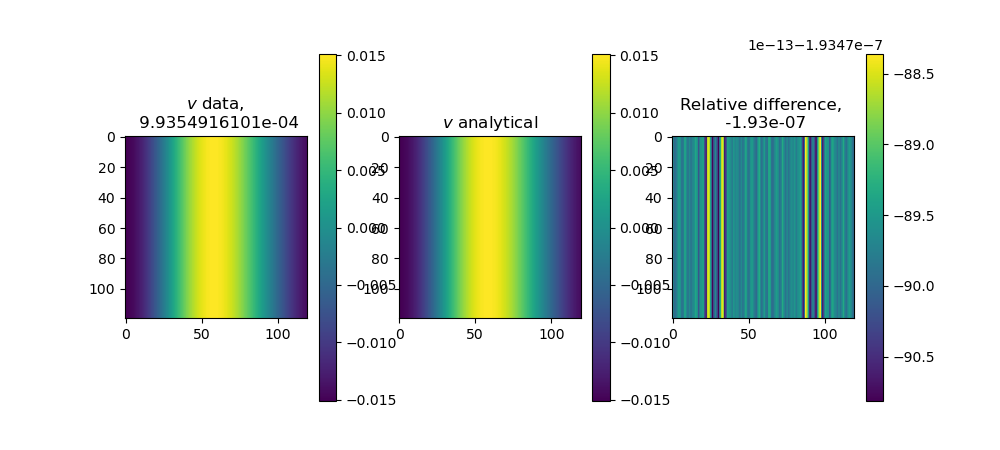

Text(0.5, 1.0, 'Relative difference, \n -1.93e-07')

In [5]:
v = Gudd[0,0,0]
vth = t*dzA/(-4+2*t*t*A*A)

v = Gudd[0,0,2]
vth = t*t*A*dzA/(-4+2*t*t*A*A)

v = Gudd[0,1,1]
vth = t*dzA/(-4+2*t*t*A*A)

v = Gudd[0,1,2]
vth = t*dzA/(4-2*t*t*A*A)

v = Gudd[0,2,2]
vth = t*dzA/(4-2*t*t*A*A)

v = Gudd[1,0,0]
vth = dzA/(4*A-2*t*t*A*A*A)

v = Gudd[1,0,2]
vth = t*dzA/(4-2*t*t*A*A)

#v = Gudd[1,1,1]
#
v = Gudd[1,1,2]
vth = (1-t*t*A*A)*dzA/(A*(4-2*t*t*A*A))

"""
v = Gudd[1,2,2]
v = Gudd[2,0,0]
v = Gudd[2,0,2]
v = Gudd[2,1,1]
v = Gudd[2,1,2]
v = Gudd[2,2,2]"""

i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[i,4:-4,4:-4])
plt.colorbar()
plt.title(r'$v$ data, '+'\n {:.10e}'.format(np.mean(v[4:-4,4:-4,4:-4])))
plt.subplot(132)
plt.imshow(vth[i,4:-4,4:-4])
plt.colorbar()
plt.title(r'$v$ analytical')
plt.subplot(133)
diff = v[4:-4,4:-4,4:-4]/vth[4:-4,4:-4,4:-4]-1
meddiff = np.median(diff)
for j in range(N-8):
    for k in range(N-8):
        for l in range(N-8):
            diff[j,k,l] = diff[j,k,l] if diff[j,k,l]!=-1 else meddiff
plt.imshow(diff[i,:,:])
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.mean(diff)))

<IPython.core.display.Javascript object>


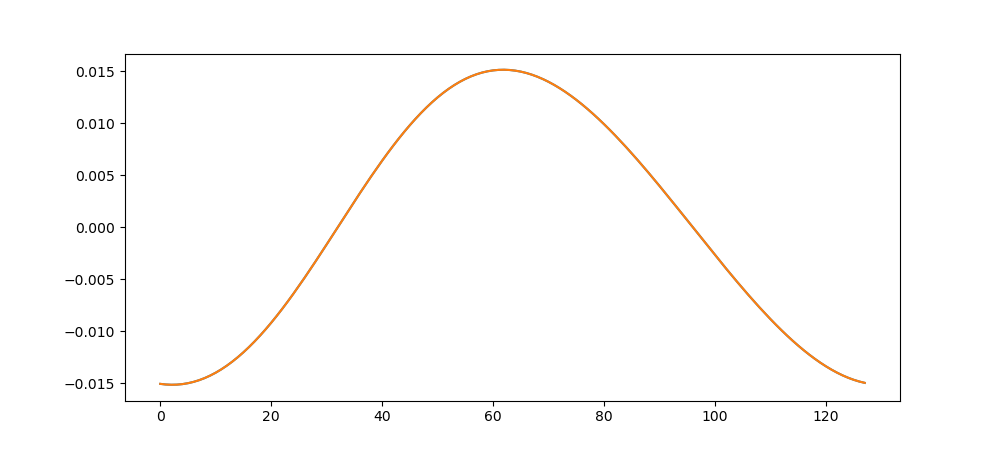

<IPython.core.display.Javascript object>


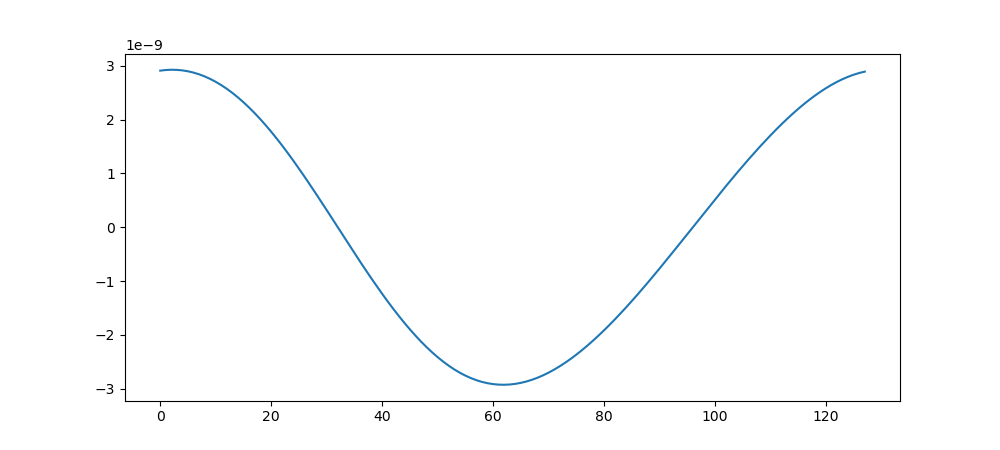

In [6]:
plt.figure(figsize=(10,4.5))
plt.plot(v[i,i,:])
plt.plot(vth[i,i,:])
plt.figure(figsize=(10,4.5))
plt.plot(v[i,i,:]-vth[i,i,:])

<IPython.core.display.Javascript object>


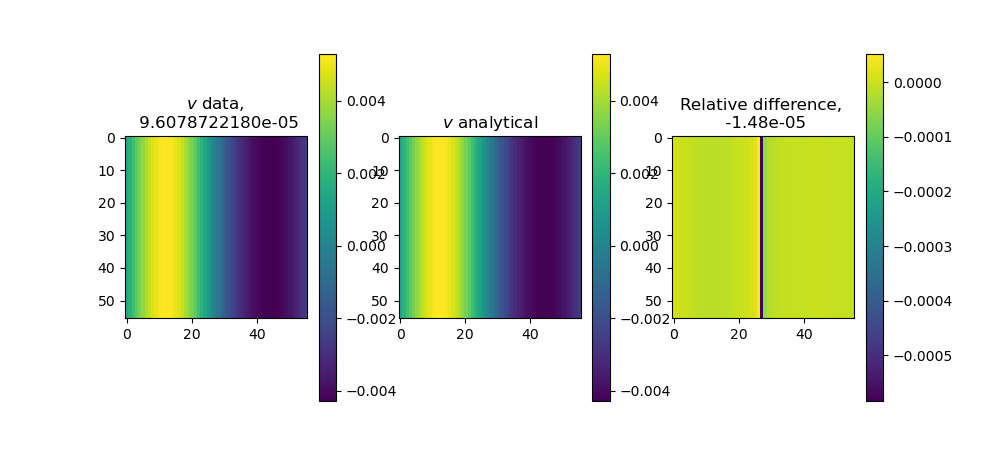

Text(0.5, 1.0, 'Relative difference, \n -1.48e-05')

In [35]:
v = FD.D3z(Gudd[0,0,2])
p1 = t*t*A*dzA
p2 = -4+2*t*t*A*A
dzp1 = t*t*(dzA*dzA+A*dzdzA)
dzp2 = 4*t*t*A*dzA
vth = (dzp1*p2 - p1*dzp2)/(p2**2)

v = FD.D3z(Gudd[2,2,2])
p1 = (1 - t*t*A*A)*dzA
p2 = (4-2*t*t*A*A)*A
dzp1 = (1 - t*t*A*A)*dzdzA+(-2*t*t*A*dzA)*dzA
dzp2 = (4-2*t*t*A*A)*dzA + (-4*t*t*A*dzA)*A
vth = (dzp1*p2 - p1*dzp2)/(p2**2)

i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[i,4:-4,4:-4])
plt.colorbar()
plt.title(r'$v$ data, '+'\n {:.10e}'.format(np.mean(v[4:-4,4:-4,4:-4])))
plt.subplot(132)
plt.imshow(vth[i,4:-4,4:-4])
plt.colorbar()
plt.title(r'$v$ analytical')
plt.subplot(133)
diff = v[4:-4,4:-4,4:-4]/vth[4:-4,4:-4,4:-4]-1
meadiff = np.mean(diff)
meddiff = np.median(diff)
#for j in range(N-8):
#    for k in range(N-8):
#        for l in range(N-8):
#            diff[j,k,l] = diff[j,k,l] if diff[j,k,l]!=-1 else meddiff
#diff[i,:,26:30] = meddiff
plt.imshow(diff[i,:,:])
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(meadiff))

## Check Ricci

In [5]:
RicciS3th = t*((2 + 3*(t*A)**2)*dzA**2 - 4*A*(-2 + (t*A)**2)*dzdzA)/(2*A*(-2 + (t*A)**2)**2)
ER75 = RicciS3 - RicciS3th
ERr75 = RicciS3/RicciS3th-1

In [26]:
convergence_order_3d(ER16, ER32)
convergence_order_3d(ER32, ER64)
convergence_order_3d(ER64, ER128)

Convergence order:  3.984316852070979
Convergence order:  3.988524598227982
Convergence order:  4.000926246129766


<IPython.core.display.Javascript object>


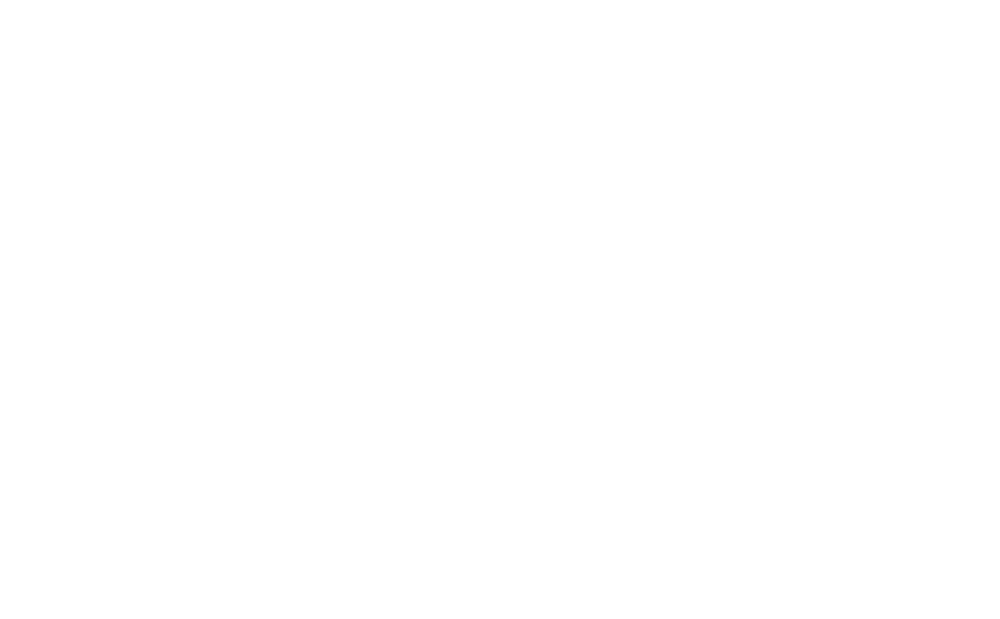

NameError: name 'ERr128' is not defined

In [6]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.semilogy(x, diag(ERr128), label='dx = L/128')
plt.semilogy(x[0::2], diag(ERr64)/16, label='dx = L/64 (scaled)')
plt.semilogy(x[0::4], diag(ERr32)/(16*16), label='dx = L/32 (scaled)')
plt.semilogy(x[0::8], diag(ERr16)/(16*16*16), label='dx = L/16 (scaled)')
plt.ylabel(r'$|{}^{(3)}R \;/\; {}^{(3)}R_{th}-1|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.savefig('/home/robynm/simulations/TestMetric_N128/Plots/3R_3+1.pdf')

x = np.arange(-1/2, 1/2, 1/128)
plt.figure()
plt.semilogy(x[0::8], abs(ERr16[8,8,:])/(16*16*16), label='dx = L/16 (scaled)')
plt.semilogy(x[0::4], abs(ERr32[16,16,:])/(16*16), label='dx = L/32 (scaled)')
plt.semilogy(x[0::2], abs(ERr64[32,32,:])/16, label='dx = L/64 (scaled)')
plt.semilogy(x, abs(ERr128[64,64,:]), label='dx = L/128')
plt.ylabel(r'$|{}^{(3)}R/{}^{(3)}R_{th}-1|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


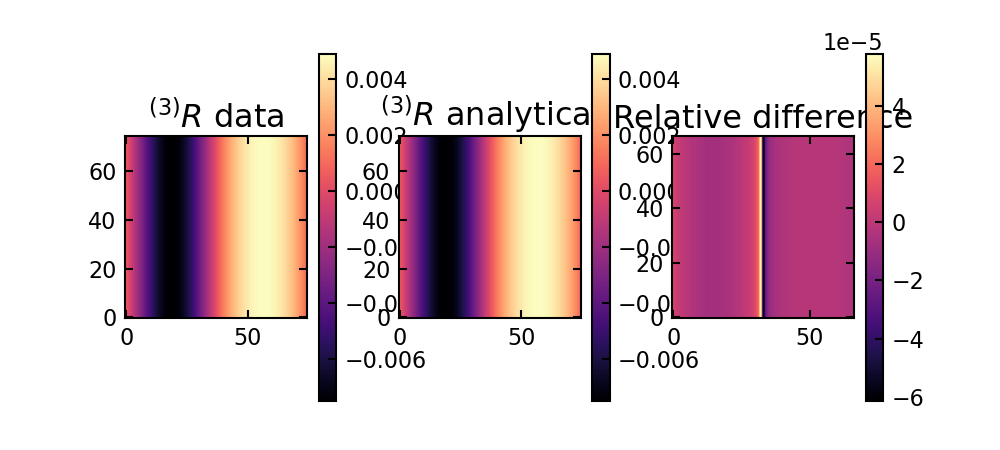

Text(0.5, 1.0, 'Relative difference')

In [6]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(RicciS3[:,i,:])
plt.colorbar()
plt.title(r'${}^{(3)}R$ data')
plt.subplot(132)
plt.imshow(RicciS3th[:,i,:])
plt.colorbar()
plt.title(r'${}^{(3)}R$ analytical')
plt.subplot(133)
diff = RicciS3[4:-4,4:-4,4:-4]/RicciS3th[4:-4,4:-4,4:-4]-1
#meddiff = np.median(diff)
#for j in range(N-8):
#    for k in range(N-8):
#        for l in range(N-8):
#            diff[j,k,l] = diff[j,k,l] if diff[j,k,l]!=-1 else meddiff
plt.imshow(diff[:,i,:])
#plt.imshow(RicciS3[4:-4,i,4:-4]/RicciS3th[4:-4,i,4:-4]-1)
plt.colorbar()
plt.title('Relative difference')

In [31]:
i = int(N/2)
p = pdiff[10,10,i]
while p<0:
    i-=1
    p = pdiff[10,10,i]
print(i)

32


In [10]:
int(41/2)

20

<IPython.core.display.Javascript object>


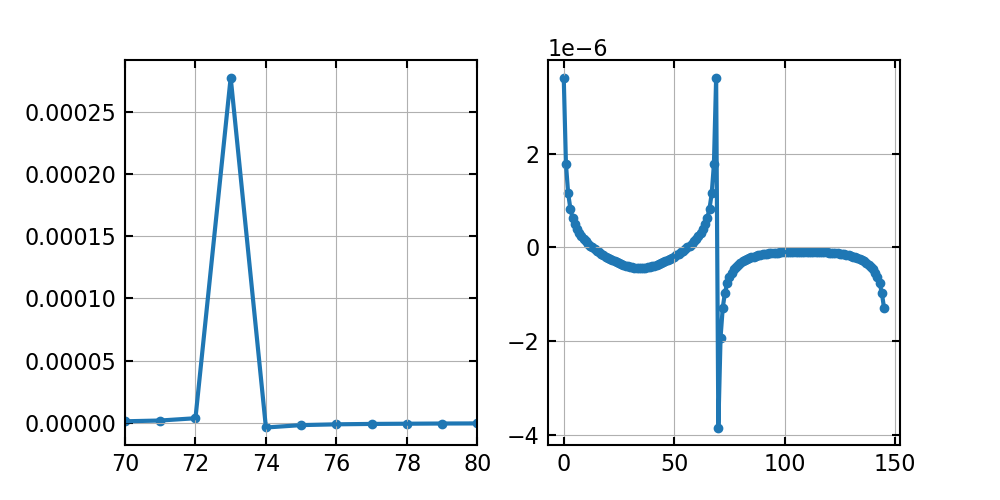

In [13]:
diff = ERr75
pdiff = list(diff)
for icut in [int(N/2)-2, int(N/2)-2, int(N/2)-2, 0, 0, 0]:
    pdiff = np.delete(pdiff, icut, axis=2)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(diff[int(N/2),int(N/2),:])
plt.scatter(range(len(diff[int(N/2),int(N/2),:])),diff[int(N/2),int(N/2),:])
plt.grid()
plt.xlim(70, 80)
plt.subplot(122)
plt.plot(pdiff[int(N/2),int(N/2),:])
plt.scatter(range(len(pdiff[int(N/2),int(N/2),:])),pdiff[int(N/2),int(N/2),:])
plt.grid()

## Check $E^2$ and $E^T$

In [7]:
udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
u_axu_b = np.einsum('a...,b...->ab...', udown, udown)
hdown = gdown4(t) + u_axu_b
G = 1
kappa = 8*np.pi*G
At2 = (A*t)**2

aux0=(8.*((A)*((t)*(dzdzA))))+(-2.*(((A)**3.)*(3.+(2.*(((t)**3.)*(dzdzA))))))
aux1=(2.*((t)*(((dzA)**2))))+((3.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux0)
aux2=((-2.+((((A)**2))*(((t)**2))))**-2.)*((3.*(((A)**5.)*(((t)**2))))+aux1)
rho = 0.25*aux2/(A*kappa)

aux0=((A)*(8.+(-8.*(((t)**3.)*(dzdzA)))))+(((A)**3.)*((6.*(((t)**2)))+(4.*(((t)**5.)*(dzdzA)))))
aux1=(-2.*(((t)**3.)*(((dzA)**2))))+((-3.*((((A)**2))*(((t)**5.)*(((dzA)**2)))))+aux0)
aux2=((-2.+((((A)**2))*(((t)**2))))**-2.)*((3.*(((A)**5.)*((t)**4.)))+aux1)
p=((0.0833333*(((t)**-2.)*aux2))/(A))/kappa

aux0=(-6.+((((A)**2))*(((t)**2))))*(((-2.+((((A)**2))*(((t)**2))))**-2.)*(dzA));
outputx=(0.25*aux0)/kappa;
aux0=((-2.+((((A)**2))*(((t)**2))))**-2.)*((2.+((((A)**2))*(((t)**2))))*(dzA));
outputy=(((0.25*aux0)/(t))/(A))/kappa;
aux0=((-2.+((((A)**2))*(((t)**2))))**-2.)*((-2.+(7.*((((A)**2))*(((t)**2)))))*(dzA));
outputz=(((-0.25*aux0)/(t))/(A))/kappa;
qdown = np.array([Box_zero, outputx, outputy, outputz])

aux0=(2.*(((A)**5.)*(((t)**5.)*(dzdzA))))+(2.*(((A)**3.)*(8.+(((t)**3.)*(dzdzA)))))
aux1=(-3.*(((A)**4.)*(((t)**5.)*(((dzA)**2)))))+((-12.*((A)*((t)*(dzdzA))))+aux0)
aux2=(6.*((t)*(((dzA)**2))))+((-7.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux1);
outputxx=(t)*aux2;
      
aux0=(8.*(((A)**3.)*(((t)**5.)*(dzdzA))))+((A)*(4.+(-16.*(((t)**3.)*(dzdzA)))));
aux1=(8.*(((t)**3.)*(((dzA)**2))))+((-12.*((((A)**2))*(((t)**5.)*(((dzA)**2)))))+aux0);
outputxy=(A)*((3.*(((A)**5.)*((t)**4.)))+aux1);
      
aux0=(2.*(((A)**3.)*(((t)**5.)*(dzdzA))))+((A)*(4.+(-4.*(((t)**3.)*(dzdzA)))));
aux1=(2.*(((t)**3.)*(((dzA)**2))))+((-3.*((((A)**2))*(((t)**5.)*(((dzA)**2)))))+aux0);
outputxz=(A)*((3.*(((A)**5.)*((t)**4.)))+aux1);
      
aux0=(2.*(((A)**3.)*(2.+(((t)**3.)*(dzdzA)))))+(2.*(((A)**5.)*((((t)**2))*(3.+(((t)**3.)*(dzdzA))))));
aux1=(-3.*(((A)**4.)*(((t)**5.)*(((dzA)**2)))))+((-12.*((A)*((t)*(dzdzA))))+aux0);
aux2=(6.*((t)*(((dzA)**2))))+((-7.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux1);
outputyy=(t)*aux2;
      
aux0=(-4.*((A)*((t)*(dzdzA))))+(2.*(((A)**3.)*(2.+(((t)**3.)*(dzdzA)))));
aux1=(2.*((t)*(((dzA)**2))))+((-3.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux0);
outputyz=3.*((t)*((-2.*(((A)**5.)*(((t)**2))))+aux1));
      
aux0=(2.*(((A)**3.)*(2.+(7.*(((t)**3.)*(dzdzA))))))+(((A)**5.)*((6.*(((t)**2)))+(-4.*(((t)**5.)*(dzdzA)))));
aux1=(6.*(((A)**4.)*(((t)**5.)*(((dzA)**2)))))+((-12.*((A)*((t)*(dzdzA))))+aux0);
aux2=(6.*((t)*(((dzA)**2))))+((-13.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux1);
outputzz=(t)*aux2;

pidown = np.array([[Box_zero, Box_zero, Box_zero, Box_zero],
                   [Box_zero, outputxx, outputxy, outputxz],
                   [Box_zero, outputxy, outputyy, outputyz],
                   [Box_zero, outputxz, outputyz, outputzz]])
pidown /= 12*kappa*At2*(-2 + At2)**2

In [8]:
Tdown4 = rho*u_axu_b+p*hdown+np.einsum('a...,b...->ab...', qdown, udown)+np.einsum('b...,a...->ab...', qdown, udown)+pidown

Edown, Eup, E2, Etrace = RCW.Weyl_E(gdown(t), gup, RicciS3, RicciTdown, Kdown(t), kappa, rho, 0.0, Tdown4[1:,1:])
At = A*t
g = At*(2 - At**2)
c1 = 2 - 3*(At**2)
c2 = 2 + 3*(At**2)
c3 = - 6 + At**2 + At**4
p1 = 2*(A**4)*c2 + 8*(At**3)*(dzA**2) + (t**4)*(dzA**4)*(3+At**2)
p2 = -4*A*(At**2)*g + A*(t**4)*c3*(dzA**2)
E2th = (p1*(c1**2) + 4*c1*p2*dzdzA - 4*A*(t**3)*c3*g*(dzdzA**2))/(96*(g**4))

EE264 = E2 - E2th
EE2r64 = E2/E2th - 1
EET64 = Etrace

<IPython.core.display.Javascript object>


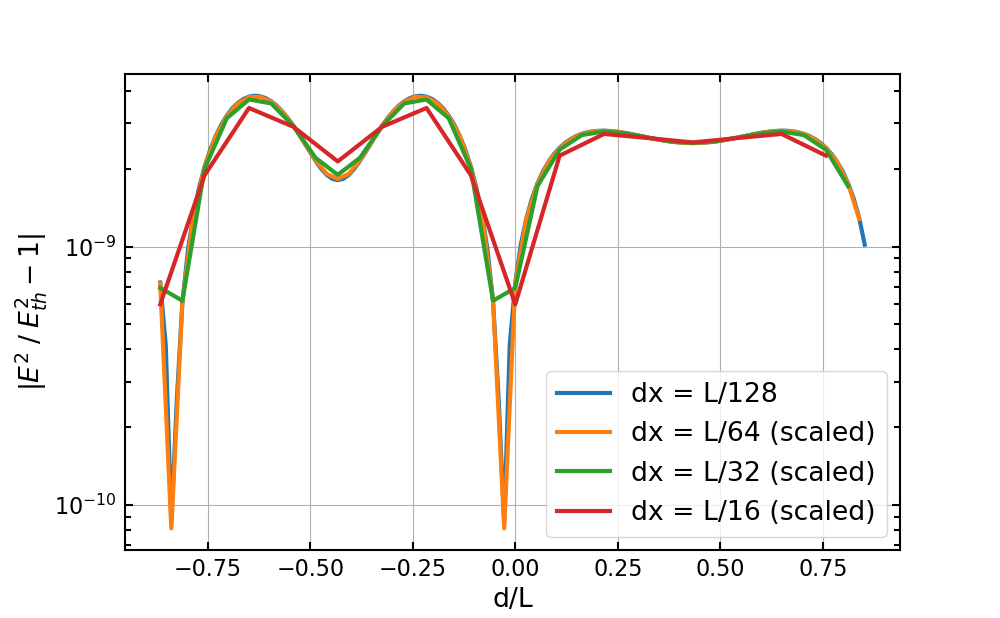

In [28]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.semilogy(x, diag(EE2r128), label='dx = L/128')
plt.semilogy(x[0::2], diag(EE2r64)/16, label='dx = L/64 (scaled)')
plt.semilogy(x[0::4], diag(EE2r32)/(16*16), label='dx = L/32 (scaled)')
plt.semilogy(x[0::8], diag(EE2r16)/(16*16*16), label='dx = L/16 (scaled)')
plt.ylabel(r'$|E^{2} \;/\; E^{2}_{th}-1|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.savefig('/home/robynm/simulations/TestMetric_N128/Plots/E2_3+1.pdf')

<IPython.core.display.Javascript object>


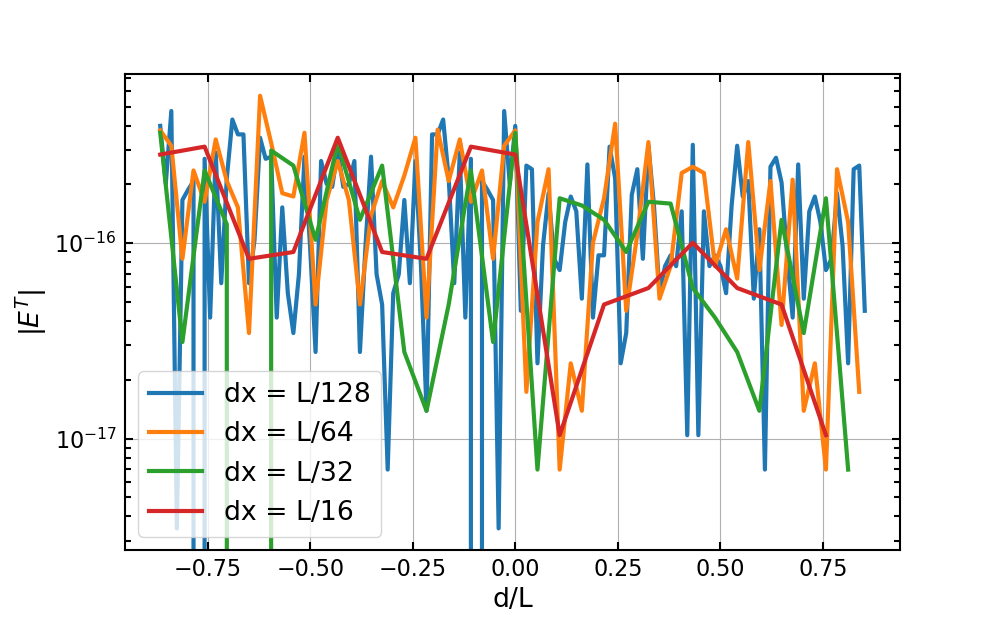

In [31]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.semilogy(x, diag(EET128), label='dx = L/128')
plt.semilogy(x[0::2], diag(EET64), label='dx = L/64')
plt.semilogy(x[0::4], diag(EET32), label='dx = L/32')
plt.semilogy(x[0::8], diag(EET16), label='dx = L/16')
plt.ylabel(r'$|E^{T}|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.savefig('/home/robynm/simulations/TestMetric_N128/Plots/ET_3+1.pdf')

In [22]:
convergence_order_3d(EE232, EE264)
convergence_order_3d(EET32, EET64)

Convergence order:  4.412772997479076
Convergence order:  -0.1551941356851033


<ipython-input-2-d34230f664c5>:4: RuntimeWarning: divide by zero encountered in log
  print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))


<IPython.core.display.Javascript object>


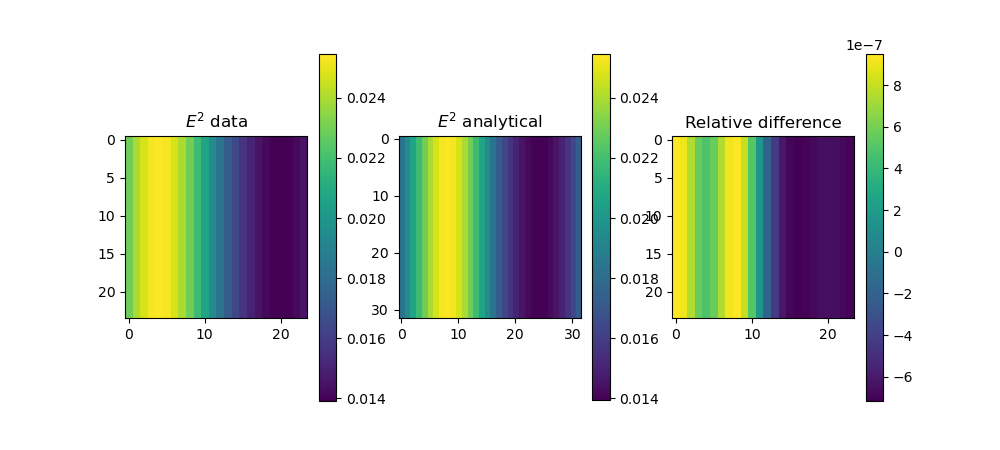

<IPython.core.display.Javascript object>


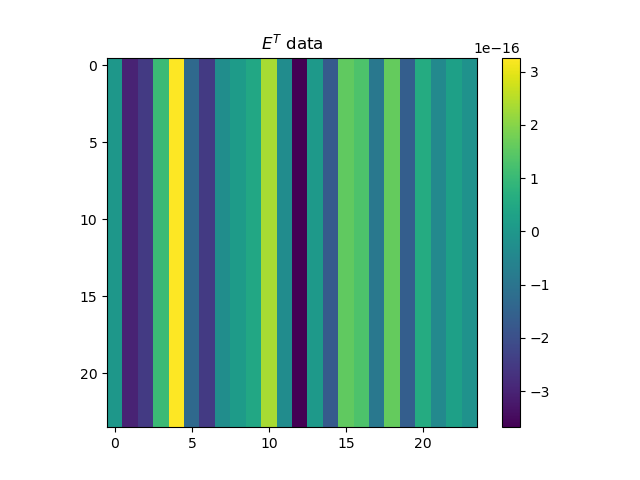

Text(0.5, 1.0, '$E^T$ data')

In [14]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(E2[4:-4,i,4:-4])
plt.colorbar()
plt.title(r'$E^2$ data')
plt.subplot(132)
plt.imshow(E2th[:,i,:])
plt.colorbar()
plt.title(r'$E^2$ analytical')
plt.subplot(133)
plt.imshow(E2[4:-4,i,4:-4]/E2th[4:-4,i,4:-4]-1)
plt.colorbar()
plt.title('Relative difference')

plt.figure()
plt.imshow(Etrace[4:-4,i,4:-4])
plt.colorbar()
plt.title(r'$E^T$ data')

## Check $B^2$ and $B^T$

In [5]:
LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = np.sqrt(abs(gdet))
LCdown[1, 2, 0, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 0, 1, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 1, 0, :, :, :] = -np.sqrt(abs(gdet))
LCdown[0, 2, 1, :, :, :] = -np.sqrt(abs(gdet))
LCdown[1, 0, 2, :, :, :] = -np.sqrt(abs(gdet))

In [9]:
Bdown, B2, Btrace = RCW.Weyl_B(LCdown, gdown(t), gup, Gudd, Kdown(t), kappa, Tdown4)
B2th = (5*abs(2*A*t - (A**3)*(t**3))*(dzA**2)*(2 + At2)**2 )/(32*At2*(-2 + At2)**5)

EB264 = B2 - B2th
EB2r64 = B2/B2th - 1
EBT64 = Btrace

In [125]:
convergence_order_3d(EB216, EB232)
convergence_order_3d(EB232, EB264)
convergence_order_3d(EB264, EB2128)
convergence_order_3d(EBT32, EBT64)

Convergence order:  3.4825040806598473
Convergence order:  3.745336502108711
Convergence order:  3.873796731685484
Convergence order:  -0.650622850989628


<IPython.core.display.Javascript object>


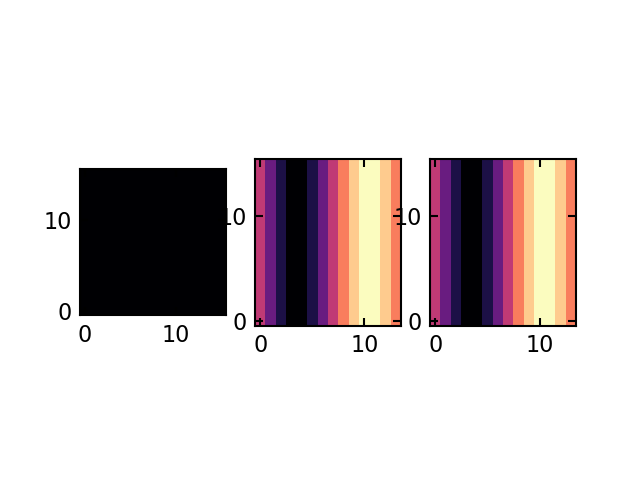

In [30]:
pEB2r64 = np.delete(np.delete(list(EB2r64[:,:,:]), int(3*N/4), axis=2), int(N/4), axis=2)
plt.figure()
plt.subplot(131)
plt.imshow(pEB2r64[:,:,10])
plt.subplot(132)
plt.imshow(pEB2r64[:,10,:])
plt.subplot(133)
plt.imshow(pEB2r64[10,:,:])

<IPython.core.display.Javascript object>


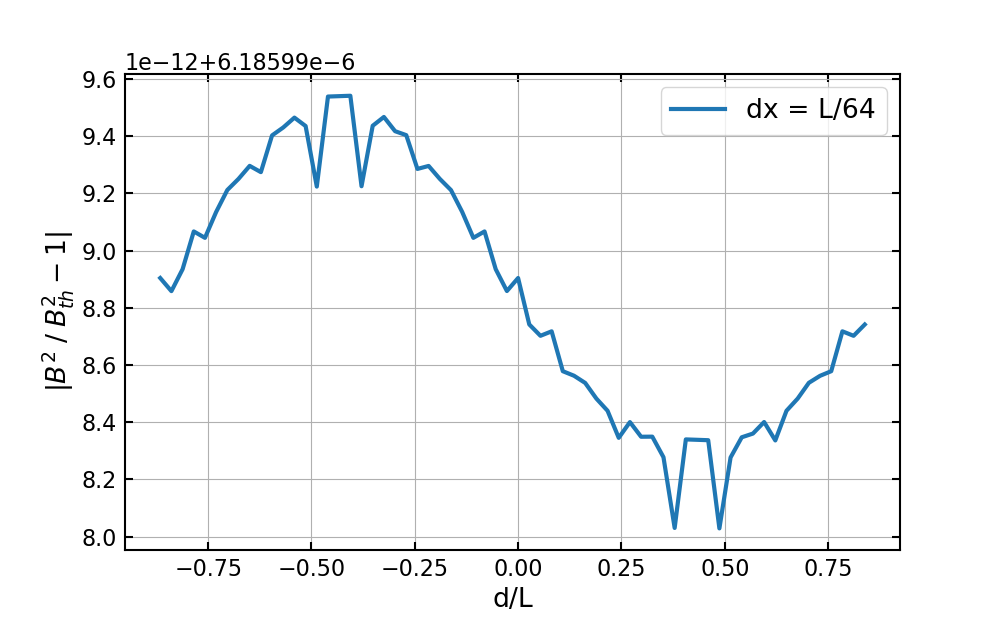

In [25]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

def myplot(xf,yf,label):
    xf = list(xf)
    yf = list(yf)
    idx = list(np.where(np.array(yf)>sorted(yf)[-3])[0])
    idx.sort(reverse=True)
    for i in idx:
        xf.pop(i)
        yf.pop(i)
    plt.plot(xf, yf, label=label)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
myplot(x[0::2], diag(EB2r64), 'dx = L/64')
#plt.plot(x[0::2], diag(EB2r64))
plt.ylabel(r'$|B^{2} \;/\; B^{2}_{th}-1|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


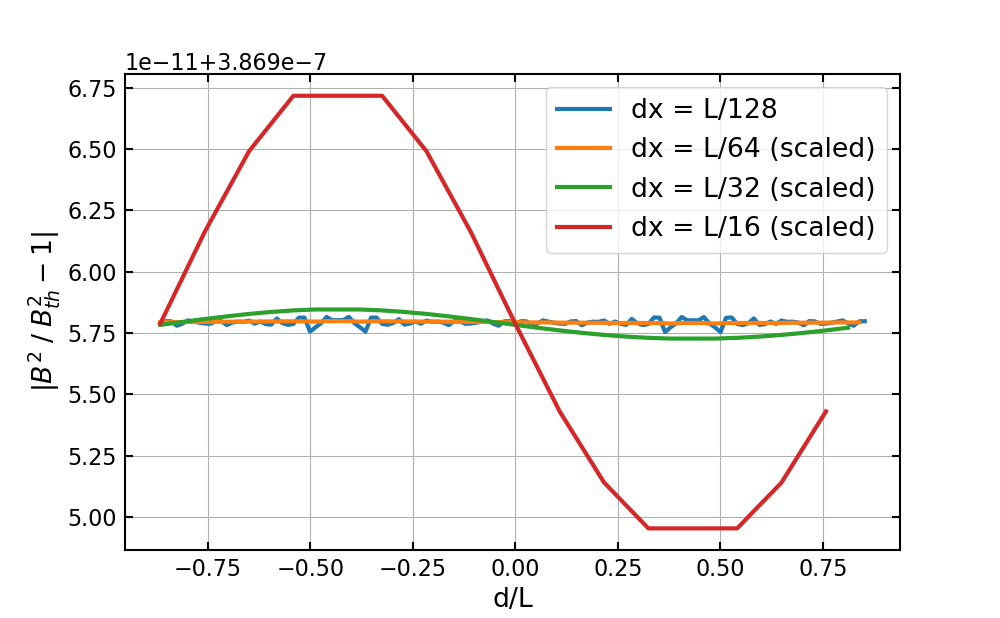

<IPython.core.display.Javascript object>


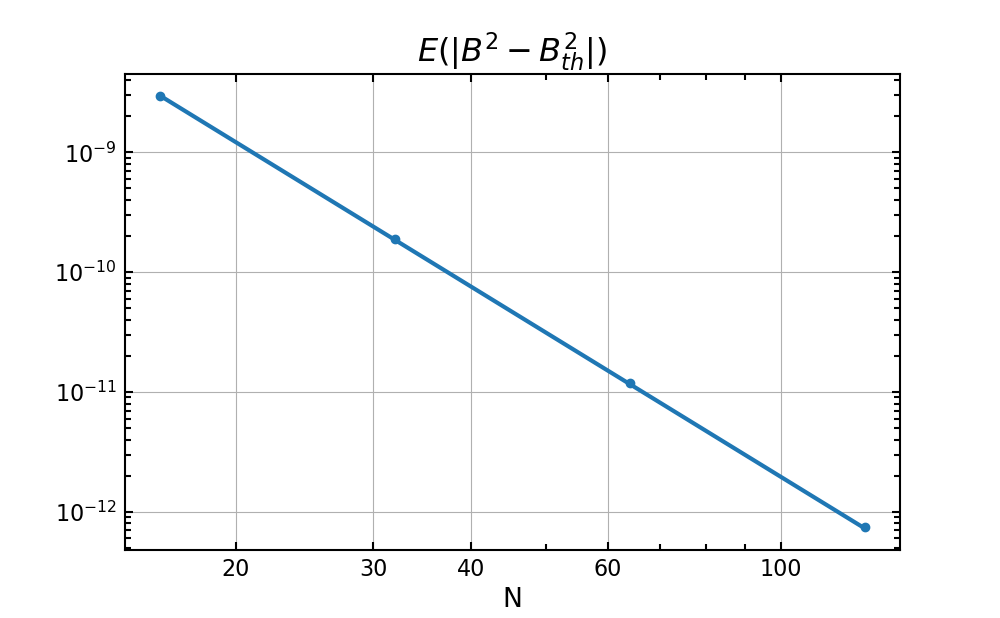

<IPython.core.display.Javascript object>


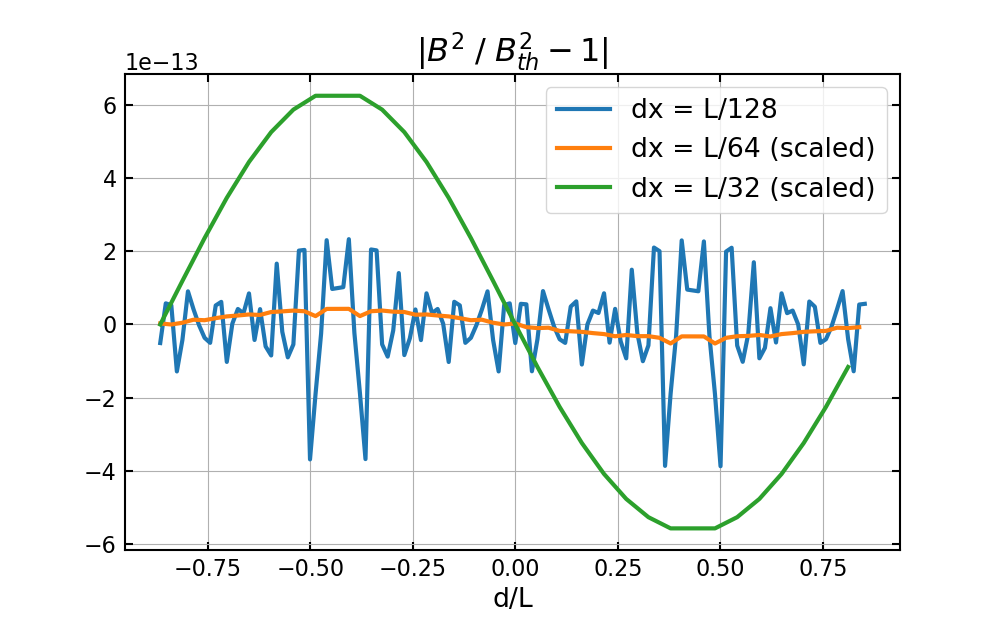

In [270]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

def myplot(xf,yf,label, withmed=True):
    xf = list(xf)
    yf = list(yf)
    idx = list(np.where(np.array(yf)>0.0004)[0])
    idx.sort(reverse=True)
    for i in idx:
        xf.pop(i)
        yf.pop(i)
    if withmed:
        plt.plot(xf, yf, label=label)
    else:
        yf = np.array(yf)
        plt.plot(xf, yf-np.median(yf), label=label)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))

myplot(x, diag(EB2r128), 'dx = L/128')
c = 2**3.9987579
myplot(x[0::2], diag(EB2r64)/c, 'dx = L/64 (scaled)')
c = 2**3.99689192
myplot(x[0::4], diag(EB2r32)/(c*c), 'dx = L/32 (scaled)')
c = 2**3.9912625
myplot(x[0::8], diag(EB2r16)/(c*c*c), 'dx = L/16 (scaled)')
plt.ylabel(r'$|B^{2} \;/\; B^{2}_{th}-1|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.savefig('/home/robynm/simulations/TestMetric_N128/Plots/B2_3+1.pdf')

def f(v):
    return np.mean(np.ma.masked_invalid(abs(v)))

plt.figure(figsize=(10,10/phi))
Ns = np.array([16, 32, 64, 128])
plt.scatter(Ns, [f(EB216), f(EB232), f(EB264), f(EB2128)])
vi = f(EB216)
c = 2**4
plt.loglog(Ns, [vi, vi/(c), vi/(c*c), vi/(c*c*c)])
plt.grid()
plt.title(r'$E(|B^{2} - B^{2}_{th}|)$')
plt.xlabel('N')
plt.xticks([20,30,40,60,100], ['20','30','40','60','100'])


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
c = 16
myplot(x, diag(EB2r128), 'dx = L/128', withmed=False)
myplot(x[0::2], diag(EB2r64)/c, 'dx = L/64 (scaled)', withmed=False)
myplot(x[0::4], diag(EB2r32)/(c*c), 'dx = L/32 (scaled)', withmed=False)
#myplot(x[0::8], diag(EB2r16)/(c*c*c), 'dx = L/16 (scaled)', withmed=False)
plt.title(r'$|B^{2} \;/\; B^{2}_{th}-1|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


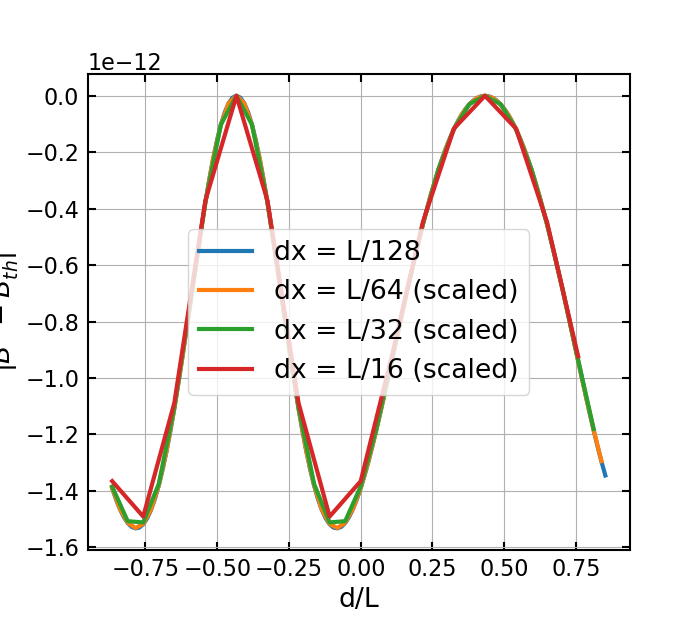

[]
[]
[]
[]


In [113]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [f[i,i,i]]
    return np.array(ffinal)

def myplot(xf,yf,label):
    xf = list(xf)
    yf = list(yf)
    idx = list(np.where(np.array(yf)<-50)[0])
    idx.sort(reverse=True)
    print(idx)
    for i in idx:
        xf.pop(i)
        yf.pop(i)
    plt.plot(xf, yf, label=label)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(7,10/phi))
myplot(x, diag(EB2128), 'dx = L/128')
myplot(x[0::2], diag(EB264)/16, 'dx = L/64 (scaled)')
myplot(x[0::4], diag(EB232)/(16*16), 'dx = L/32 (scaled)')
myplot(x[0::8], diag(EB216)/(16*16*16), 'dx = L/16 (scaled)')
plt.ylabel(r'$|B^{2} - B^{2}_{th}|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.ylim(1e-7, 1e-6)
#plt.savefig('/home/robynm/simulations/TestMetric_N128/Plots/E2_3+1.pdf')

<IPython.core.display.Javascript object>


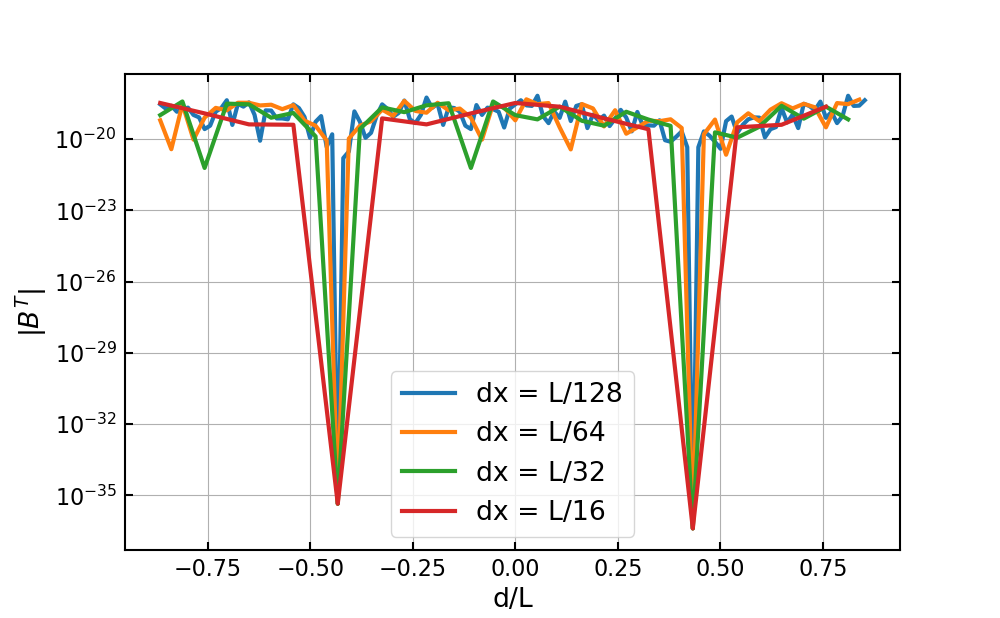

In [105]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.semilogy(x, diag(EBT128), label='dx = L/128')
plt.semilogy(x[0::2], diag(EBT64), label='dx = L/64')
plt.semilogy(x[0::4], diag(EBT32), label='dx = L/32')
plt.semilogy(x[0::8], diag(EBT16), label='dx = L/16')
plt.ylabel(r'$|B^{T}|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.savefig('/home/robynm/simulations/TestMetric_N128/Plots/BT_3+1.pdf')

<IPython.core.display.Javascript object>


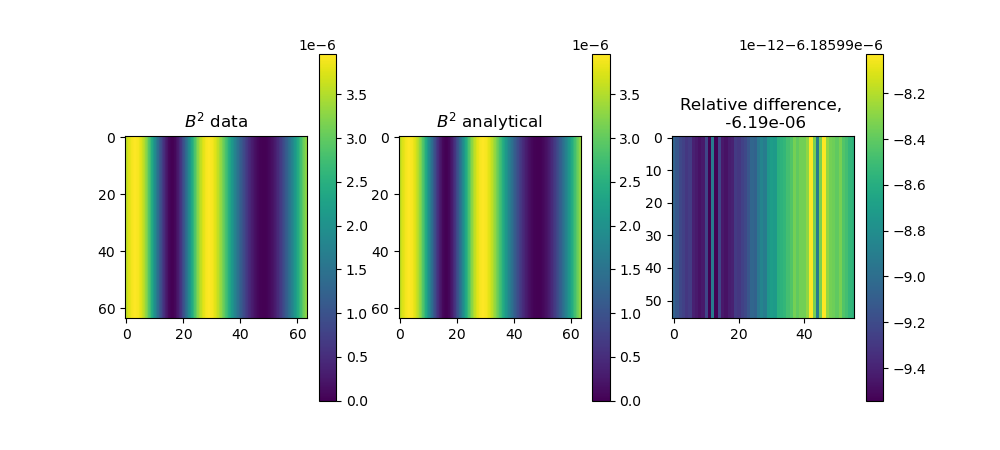

<IPython.core.display.Javascript object>


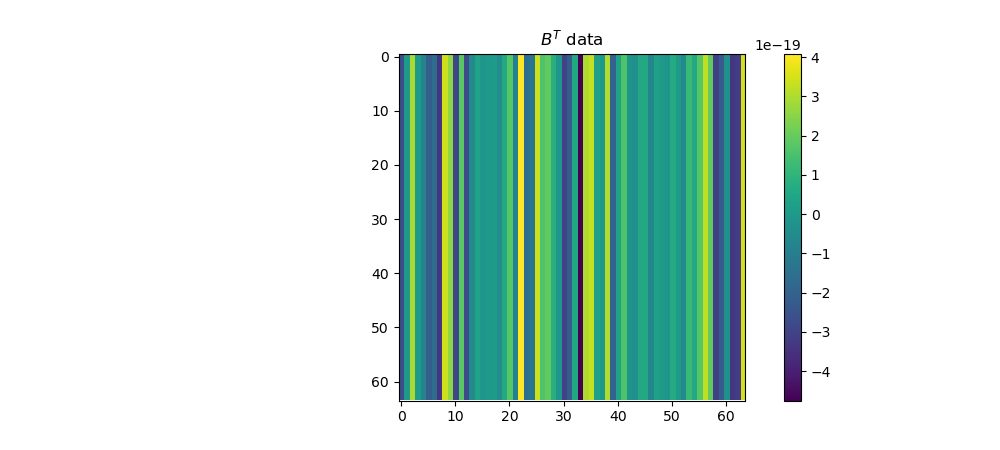

Text(0.5, 1.0, '$B^T$ data')

In [44]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(B2[:,i,:])
plt.colorbar()
plt.title(r'$B^2$ data')
plt.subplot(132)
plt.imshow(B2th[:,i,:])
plt.colorbar()
plt.title(r'$B^2$ analytical')
plt.subplot(133)
#diff = B2/B2th-1
#plt.imshow([[val if val!=-1 else np.median(diff[:,i,:]) for val in diff[j,i,:]] for j in range(N)])
#plt.colorbar()
#plt.title('Relative difference')

diff = B2[4:-4,4:-4,4:-4]/B2th[4:-4,4:-4,4:-4]-1
meddiff = np.median(diff)
for j in range(N-8):
    for k in range(N-8):
        for l in range(N-8):
            diff[j,k,l] = diff[j,k,l] if diff[j,k,l]!=-1 else meddiff
            if abs(B2th[j+4,k+4,l+4])<1e-20:
                diff[j,k,l]=meddiff
plt.imshow(diff[:,i,:])
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.average(diff)))

plt.figure(figsize=(10,4.5))
plt.imshow(Btrace[:,i,:])
plt.colorbar()
plt.title(r'$B^T$ data')

# Geometrical

In [4]:
tIN = 1.05
tF = 1.15
dt = 0.01*dx

In [22]:
for it, t in enumerate(np.arange(tIN, tF, dt)):
    gd = gdown(t)
    Kd = Kdown(t)
    
    fname = '/home/robynm/simulations/TestMetric_N'+str(N)+'/all_iterations/TestMetric_it_{:06d}.hdf5'.format(it)
    with h5py.File(fname, 'w') as fnew:
        fnew['gxx it={}'.format(it)] = gd[0,0]
        fnew['gxy it={}'.format(it)] = gd[0,1]
        fnew['gxz it={}'.format(it)] = gd[0,2]
        fnew['gyy it={}'.format(it)] = gd[1,1]
        fnew['gyz it={}'.format(it)] = gd[1,2]
        fnew['gzz it={}'.format(it)] = gd[2,2]
        fnew['kxx it={}'.format(it)] = Kd[0,0]
        fnew['kxy it={}'.format(it)] = Kd[0,1]
        fnew['kxz it={}'.format(it)] = Kd[0,2]
        fnew['kyy it={}'.format(it)] = Kd[1,1]
        fnew['kyz it={}'.format(it)] = Kd[1,2]
        fnew['kzz it={}'.format(it)] = Kd[2,2]

In [5]:
t = 1.1
it = np.argmin(abs(np.arange(tIN, tF, dt)-t))
fname = '/home/robynm/simulations/TestMetric_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
f = h5py.File(fname, 'r')
print(f.keys())
At = A*t
g = At*(2 - At**2)
c1 = 2 - 3*(At**2)
c2 = 2 + 3*(At**2)
c3 = - 6 + At**2 + At**4

<KeysViewHDF5 ['B2', 'Btrace', 'E2', 'Etrace', 'Exx', 'Eyy', 'RicciS4', 'dtdtgdown4', 'dtdxgdown4', 'dtdygdown4', 'dtdzgdown4', 'dtgdown4', 'dxgdown4', 'dygdown4', 'dzgdown4']>


## Check Ricci

In [9]:
RicciS4 = np.array(f['RicciS4'])
RicciS4th = (A/(2*g*g))*( (-2*A + (t**3)*(dzA**2))*c2 + 4*g*(t**2)*dzdzA )
ER464 = RicciS4 - RicciS4th

In [25]:
convergence_order_3d(ER432, ER464)

Convergence order:  4.01404115921244


<IPython.core.display.Javascript object>


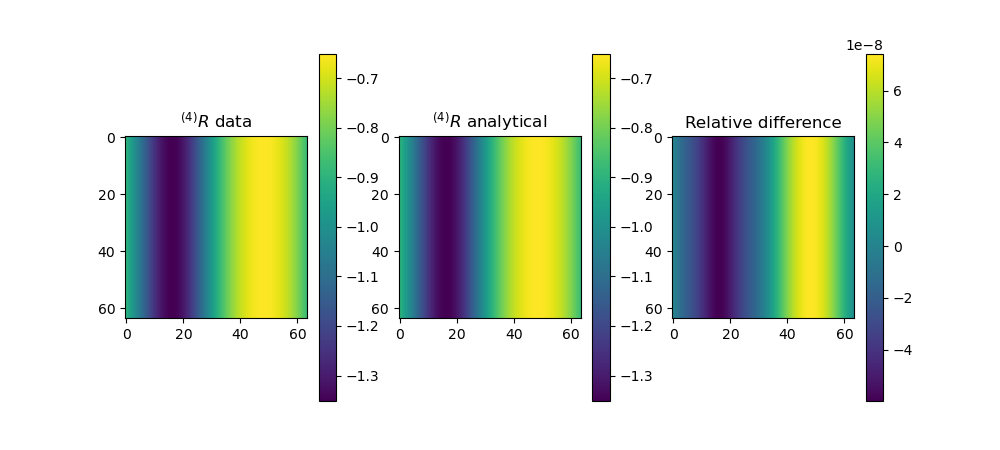

Text(0.5, 1.0, 'Relative difference')

In [10]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(RicciS4[:,i,:])
plt.colorbar()
plt.title(r'${}^{(4)}R$ data')
plt.subplot(132)
plt.imshow(RicciS4th[:,i,:])
plt.colorbar()
plt.title(r'${}^{(4)}R$ analytical')
plt.subplot(133)
plt.imshow(RicciS4[:,i,:]/RicciS4th[:,i,:]-1)
plt.colorbar()
plt.title('Relative difference')

## Check $B^2$ and $B^T$

In [6]:
B2 = np.array(f['B2'])
At2 = (A*t)**2
B2th = (5*abs(2*A*t - (A**3)*(t**3))*(dzA**2)*(2 + At2)**2 )/(32*At2*(-2 + At2)**5)
Btrace = np.array(f['Btrace'])
EB264 = B2 - B2th
EBT64 = Btrace

In [28]:
convergence_order_3d(EB232, EB264)
convergence_order_3d(EBT32, EBT64)

Convergence order:  3.7403021389263067
Convergence order:  -1.4472750530753264


<ipython-input-2-d34230f664c5>:3: RuntimeWarning: invalid value encountered in true_divide
  c = abs(E1)/abs(E2)


<IPython.core.display.Javascript object>


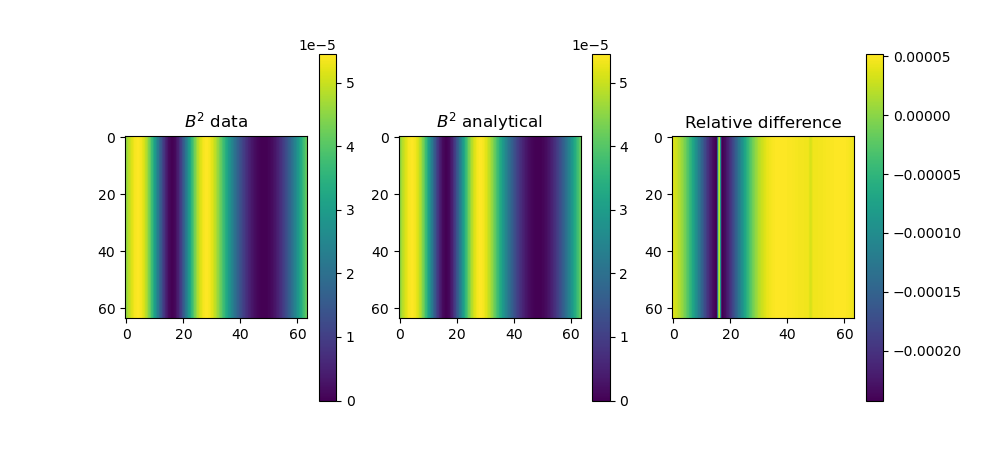

<IPython.core.display.Javascript object>


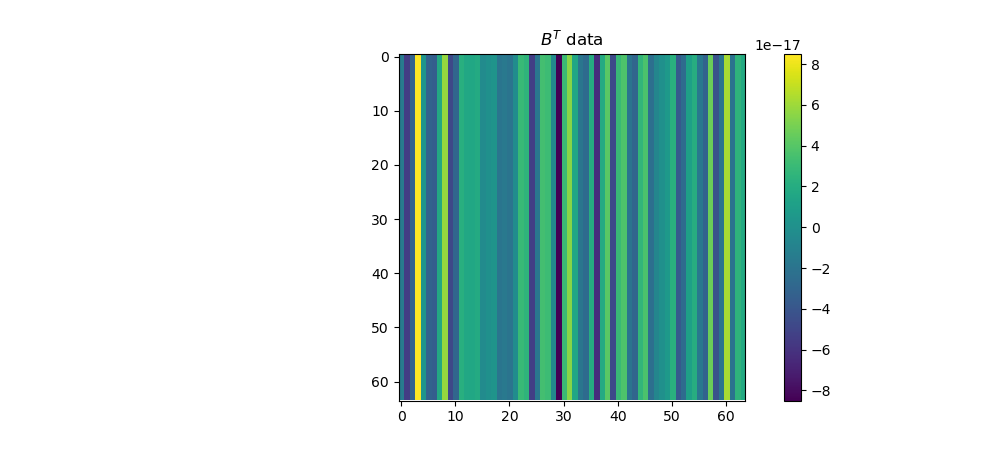

Text(0.5, 1.0, '$B^T$ data')

In [7]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(B2[:,i,:])
plt.colorbar()
plt.title(r'$B^2$ data')
plt.subplot(132)
plt.imshow(B2th[:,i,:])
plt.colorbar()
plt.title(r'$B^2$ analytical')
plt.subplot(133)
diff = B2/B2th-1
plt.imshow([[val if val!=-1 else np.median(diff[:,i,:]) for val in diff[j,i,:]] for j in range(N)])
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Btrace[:,i,:])
plt.colorbar()
plt.title(r'$B^T$ data')

## Check $E^2$ and $E^T$

In [8]:
p1 = 2*(A**4)*c2 + 8*(At**3)*(dzA**2) + (t**4)*(dzA**4)*(3+At**2)
p2 = -4*A*(At**2)*g + A*(t**4)*c3*(dzA**2)
E2th = (p1*(c1**2) + 4*c1*p2*dzdzA - 4*A*(t**3)*c3*g*(dzdzA**2))/(96*(g**4))

E2 = np.array(f['E2'])
Etrace = np.array(f['Etrace'])

EE264 = E2 - E2th
EET64 = Etrace

In [31]:
convergence_order_3d(EE232, EE264)
convergence_order_3d(EET32, EET64)

Convergence order:  3.990803505006771
Convergence order:  -0.8038061078333985


<ipython-input-2-d34230f664c5>:3: RuntimeWarning: divide by zero encountered in true_divide
  c = abs(E1)/abs(E2)


<IPython.core.display.Javascript object>


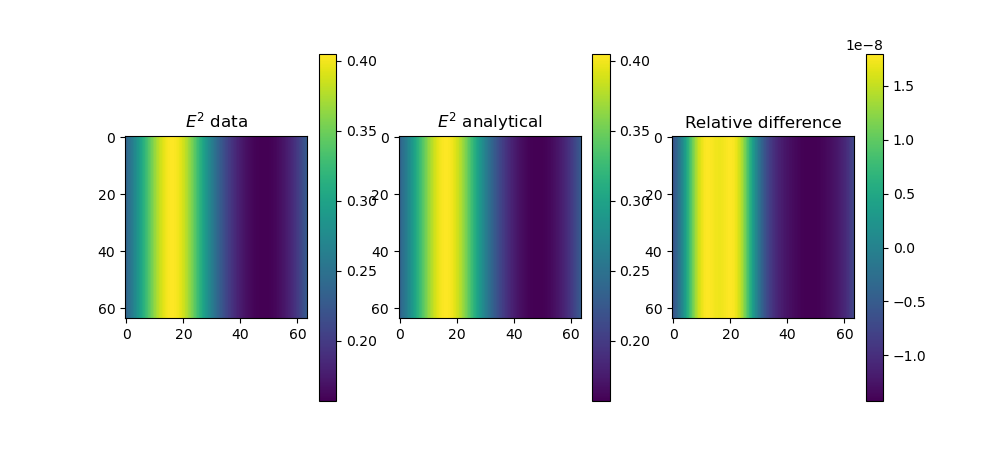

<IPython.core.display.Javascript object>


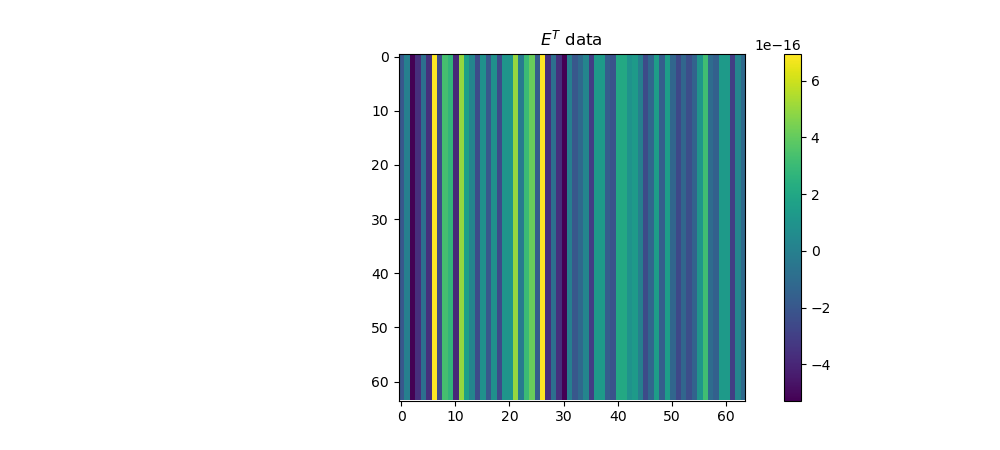

Text(0.5, 1.0, '$E^T$ data')

In [9]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(E2[:,i,:])
plt.colorbar()
plt.title(r'$E^2$ data')
plt.subplot(132)
plt.imshow(E2th[:,i,:])
plt.colorbar()
plt.title(r'$E^2$ analytical')
plt.subplot(133)
plt.imshow(E2[:,i,:]/E2th[:,i,:]-1)
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Etrace[:,i,:])
plt.colorbar()
plt.title(r'$E^T$ data')

# Invariants

In [6]:
t = 1.5
gd = gdown(t)
glist = [gd[0,0], gd[0,1], gd[0,2], gd[1,1], gd[1,2], gd[2,2]]
gdet = RRead.det3(glist)
gup = RRead.inv3(glist)
RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
Gudd = RCW.Christoffel_symbol(gd, gup)
RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)
udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
u_axu_b = np.einsum('a...,b...->ab...', udown, udown)
hdown = gdown4(t) + u_axu_b
G = 1
kappa = 8*np.pi*G
At2 = (A*t)**2

aux0=(8.*((A)*((t)*(dzdzA))))+(-2.*(((A)**3.)*(3.+(2.*(((t)**3.)*(dzdzA))))))
aux1=(2.*((t)*(((dzA)**2))))+((3.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux0)
aux2=((-2.+((((A)**2))*(((t)**2))))**-2.)*((3.*(((A)**5.)*(((t)**2))))+aux1)
rho = 0.25*aux2/(A*kappa)

aux0=((A)*(8.+(-8.*(((t)**3.)*(dzdzA)))))+(((A)**3.)*((6.*(((t)**2)))+(4.*(((t)**5.)*(dzdzA)))))
aux1=(-2.*(((t)**3.)*(((dzA)**2))))+((-3.*((((A)**2))*(((t)**5.)*(((dzA)**2)))))+aux0)
aux2=((-2.+((((A)**2))*(((t)**2))))**-2.)*((3.*(((A)**5.)*((t)**4.)))+aux1)
p=((0.0833333*(((t)**-2.)*aux2))/(A))/kappa

aux0=(-6.+((((A)**2))*(((t)**2))))*(((-2.+((((A)**2))*(((t)**2))))**-2.)*(dzA));
outputx=(0.25*aux0)/kappa;
aux0=((-2.+((((A)**2))*(((t)**2))))**-2.)*((2.+((((A)**2))*(((t)**2))))*(dzA));
outputy=(((0.25*aux0)/(t))/(A))/kappa;
aux0=((-2.+((((A)**2))*(((t)**2))))**-2.)*((-2.+(7.*((((A)**2))*(((t)**2)))))*(dzA));
outputz=(((-0.25*aux0)/(t))/(A))/kappa;
qdown = np.array([Box_zero, outputx, outputy, outputz])

aux0=(2.*(((A)**5.)*(((t)**5.)*(dzdzA))))+(2.*(((A)**3.)*(8.+(((t)**3.)*(dzdzA)))))
aux1=(-3.*(((A)**4.)*(((t)**5.)*(((dzA)**2)))))+((-12.*((A)*((t)*(dzdzA))))+aux0)
aux2=(6.*((t)*(((dzA)**2))))+((-7.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux1);
outputxx=(t)*aux2;
      
aux0=(8.*(((A)**3.)*(((t)**5.)*(dzdzA))))+((A)*(4.+(-16.*(((t)**3.)*(dzdzA)))));
aux1=(8.*(((t)**3.)*(((dzA)**2))))+((-12.*((((A)**2))*(((t)**5.)*(((dzA)**2)))))+aux0);
outputxy=(A)*((3.*(((A)**5.)*((t)**4.)))+aux1);
      
aux0=(2.*(((A)**3.)*(((t)**5.)*(dzdzA))))+((A)*(4.+(-4.*(((t)**3.)*(dzdzA)))));
aux1=(2.*(((t)**3.)*(((dzA)**2))))+((-3.*((((A)**2))*(((t)**5.)*(((dzA)**2)))))+aux0);
outputxz=(A)*((3.*(((A)**5.)*((t)**4.)))+aux1);
      
aux0=(2.*(((A)**3.)*(2.+(((t)**3.)*(dzdzA)))))+(2.*(((A)**5.)*((((t)**2))*(3.+(((t)**3.)*(dzdzA))))));
aux1=(-3.*(((A)**4.)*(((t)**5.)*(((dzA)**2)))))+((-12.*((A)*((t)*(dzdzA))))+aux0);
aux2=(6.*((t)*(((dzA)**2))))+((-7.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux1);
outputyy=(t)*aux2;
      
aux0=(-4.*((A)*((t)*(dzdzA))))+(2.*(((A)**3.)*(2.+(((t)**3.)*(dzdzA)))));
aux1=(2.*((t)*(((dzA)**2))))+((-3.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux0);
outputyz=3.*((t)*((-2.*(((A)**5.)*(((t)**2))))+aux1));
      
aux0=(2.*(((A)**3.)*(2.+(7.*(((t)**3.)*(dzdzA))))))+(((A)**5.)*((6.*(((t)**2)))+(-4.*(((t)**5.)*(dzdzA)))));
aux1=(6.*(((A)**4.)*(((t)**5.)*(((dzA)**2)))))+((-12.*((A)*((t)*(dzdzA))))+aux0);
aux2=(6.*((t)*(((dzA)**2))))+((-13.*((((A)**2))*(((t)**3.)*(((dzA)**2)))))+aux1);
outputzz=(t)*aux2;

pidown = np.array([[Box_zero, Box_zero, Box_zero, Box_zero],
                   [Box_zero, outputxx, outputxy, outputxz],
                   [Box_zero, outputxy, outputyy, outputyz],
                   [Box_zero, outputxz, outputyz, outputzz]])
pidown /= 12*kappa*At2*(-2 + At2)**2
Tdown4 = rho*u_axu_b+p*hdown+np.einsum('a...,b...->ab...', qdown, udown)+np.einsum('b...,a...->ab...', qdown, udown)+pidown
LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = np.sqrt(abs(gdet))
LCdown[1, 2, 0, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 0, 1, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 1, 0, :, :, :] = -np.sqrt(abs(gdet))
LCdown[0, 2, 1, :, :, :] = -np.sqrt(abs(gdet))
LCdown[1, 0, 2, :, :, :] = -np.sqrt(abs(gdet))
LCuud3 = np.einsum('ae...,bf...,efc...->abc...', gup, gup, LCdown)
nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])

Bdict = RCW.Weyl_B(gd, gup, nup, LCuud3, Gudd, Kdown(t))
Edict = RCW.Weyl_E(gd, gup, LCuud3, Gudd, RicciS3, RicciTdown, Kdown(t), kappa, Tdown4[1:,1:])
invar_dict = RCW.Weyl_Invar(gd, Edict, Bdict)

/home/robynm/mycodes/ebweyl/data_analysis_codes/tools/Ricci_CoGrad_Weyl.py:304: RuntimeWarning: invalid value encountered in sqrt
  return {'LB':LB, 'M':M, 'J':J, 'I':I, 'S':S, 'LS':LS, 'K':K, 'N':N, '|E|':np.sqrt(Edict['E2']), '|B|':np.sqrt(Bdict['B2']), 'psi0':psi[0], 'psi1':psi[1], 'psi2':psi[2], 'psi3':psi[3], 'psi4':psi[4]}


In [7]:
print('psi0 = ', np.average(abs(invar_dict['psi0'][4:-4, 4:-4, 4:-4])))
print('psi1 = ', np.average(abs(invar_dict['psi1'][4:-4, 4:-4, 4:-4])))
print('psi2 = ', np.average(abs(invar_dict['psi2'][4:-4, 4:-4, 4:-4])))
print('psi3 = ', np.average(abs(invar_dict['psi3'][4:-4, 4:-4, 4:-4])))
print('psi4 = ', np.average(abs(invar_dict['psi4'][4:-4, 4:-4, 4:-4])))

psi0 =  0.039302996244259446
psi1 =  0.0429768059818686
psi2 =  0.01306687962579178
psi3 =  0.042976787009126764
psi4 =  0.0391377805592395


In [8]:
icut = 4
print('S-1 = ', np.average(abs(invar_dict['S'][icut:-icut, icut:-icut, icut:-icut])-1)) # ill defined as I=J=0
I = np.array(invar_dict['I'])
J = np.array(invar_dict['J'])
Scrit = I*I*I-27*J*J
print('Scrit = ', np.average(abs(Scrit[icut:-icut, icut:-icut, icut:-icut])))
print('I = ', np.average(abs(invar_dict['I'][icut:-icut, icut:-icut, icut:-icut])))
print('J = ', np.average(abs(invar_dict['J'][icut:-icut, icut:-icut, icut:-icut])))
print('K = ', np.average(abs(invar_dict['K'][icut:-icut, icut:-icut, icut:-icut])))
print('LS = ', np.average(abs(invar_dict['LS'][icut:-icut, icut:-icut, icut:-icut])))
print('N = ', np.average(abs(invar_dict['N'][icut:-icut, icut:-icut, icut:-icut])))
print('|E| = ', np.average(abs(invar_dict['|E|'][icut:-icut, icut:-icut, icut:-icut])))
print('|B| = ', np.mean(np.ma.masked_invalid(abs(invar_dict['|B|'][icut:-icut, icut:-icut, icut:-icut]))))

S-1 =  -0.5842736590079147
Scrit =  5.609109632180134e-07
I =  0.009567220021102383
J =  0.0001203435338770829
K =  0.0037284837348155945
LS =  0.002390174763292497
N =  5.571401200369061e-05
|E| =  0.13745749876362756
|B| =  0.001193561391862191


<IPython.core.display.Javascript object>


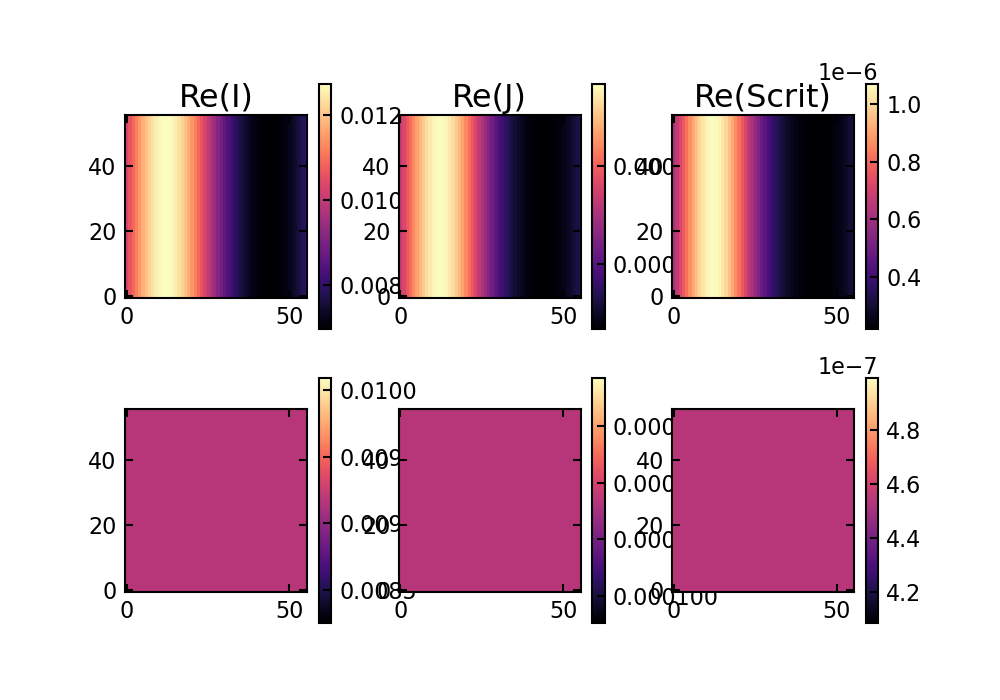

<IPython.core.display.Javascript object>


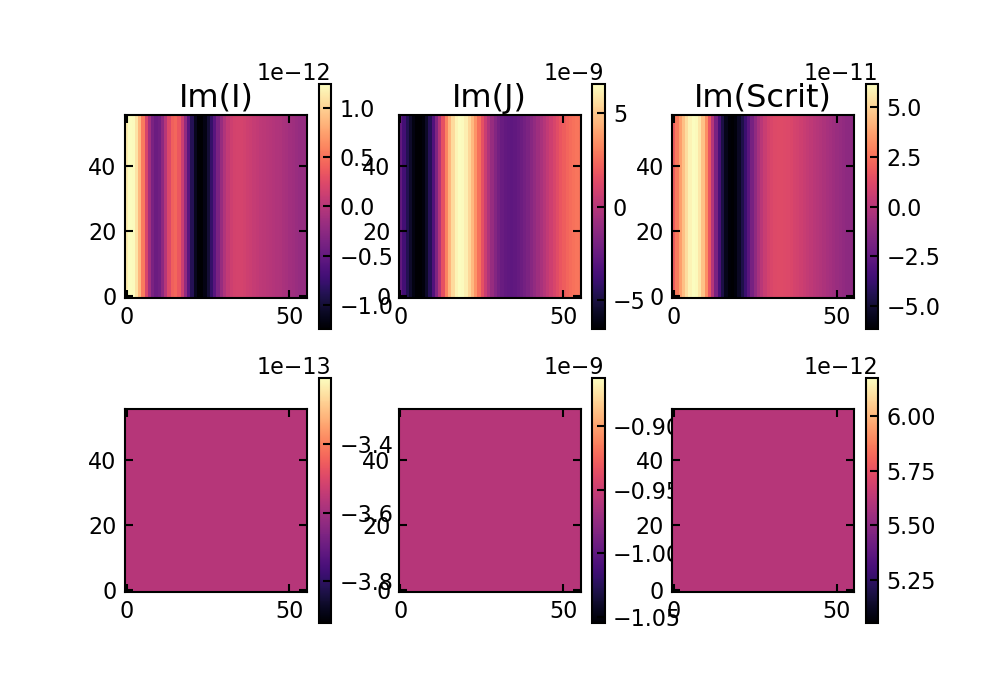

In [9]:
i = 32
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.real(invar_dict['I'][icut:-icut,i,icut:-icut]))
plt.title('Re(I)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.real(invar_dict['I'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.real(invar_dict['J'][icut:-icut,i,icut:-icut]))
plt.title('Re(J)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.real(invar_dict['J'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.real(Scrit[icut:-icut,i,icut:-icut]))
plt.title('Re(Scrit)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.real(Scrit[icut:-icut,icut:-icut,i]))
plt.colorbar()


plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.imag(invar_dict['I'][icut:-icut,i,icut:-icut]))
plt.title('Im(I)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.imag(invar_dict['I'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.imag(invar_dict['J'][icut:-icut,i,icut:-icut]))
plt.title('Im(J)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.imag(invar_dict['J'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.imag(Scrit[icut:-icut,i,icut:-icut]))
plt.title('Im(Scrit)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.imag(Scrit[icut:-icut,icut:-icut,i]))
plt.colorbar()

<IPython.core.display.Javascript object>


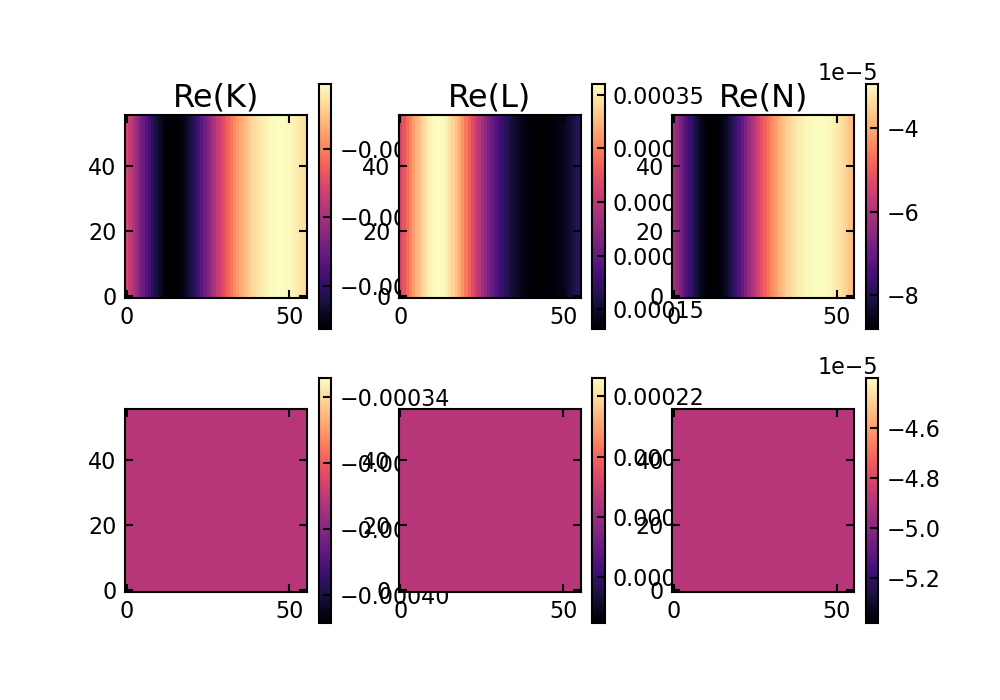

<IPython.core.display.Javascript object>


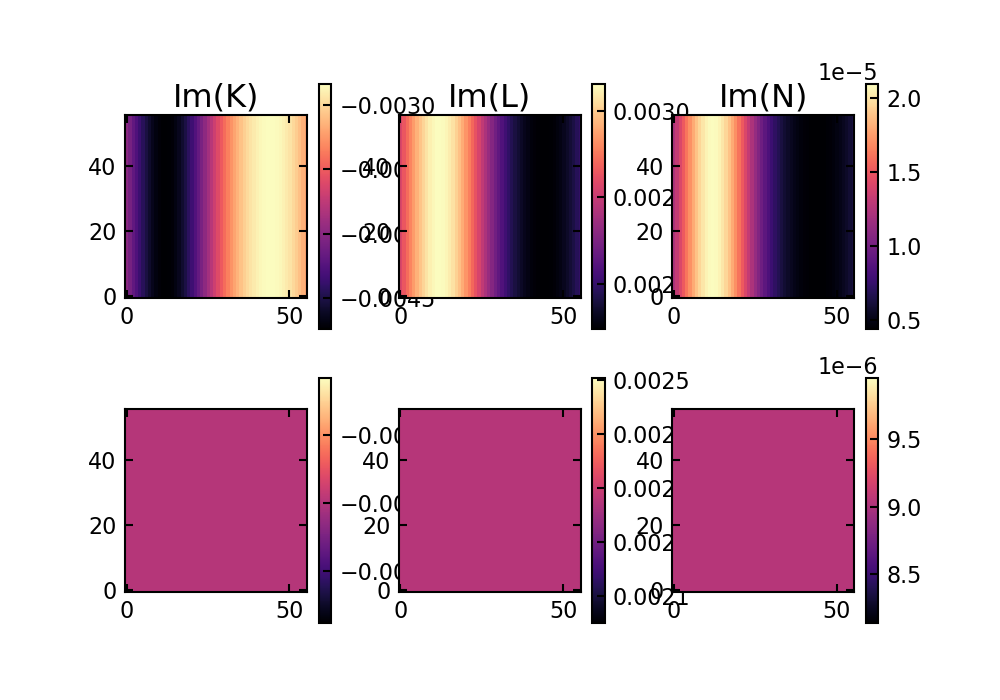

In [11]:
i = 32
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.real(invar_dict['K'][icut:-icut,i,icut:-icut]))
plt.title('Re(K)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.real(invar_dict['K'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.real(invar_dict['LS'][icut:-icut,i,icut:-icut]))
plt.title('Re(L)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.real(invar_dict['LS'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.real(invar_dict['N'][icut:-icut,i,icut:-icut]))
plt.title('Re(N)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.real(invar_dict['N'][icut:-icut,icut:-icut,i]))
plt.colorbar()


plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.imag(invar_dict['K'][icut:-icut,i,icut:-icut]))
plt.title('Im(K)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.imag(invar_dict['K'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.imag(invar_dict['LS'][icut:-icut,i,icut:-icut]))
plt.title('Im(L)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.imag(invar_dict['LS'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.imag(invar_dict['N'][icut:-icut,i,icut:-icut]))
plt.title('Im(N)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.imag(invar_dict['N'][icut:-icut,icut:-icut,i]))
plt.colorbar()

In [12]:
dE = abs(invar_dict['|E|'])
dB = abs(invar_dict['|B|'])
dB[np.isnan(dB)] = 0
dS = abs(np.array(invar_dict['S']))
I = np.array(invar_dict['I'])
J = np.array(invar_dict['J'])
Scrit = I*I*I-27*J*J
dScrit = abs(Scrit)
dI = abs(I)
dJ = abs(J)
dLS = abs(np.array(invar_dict['LS']))
dK = abs(np.array(invar_dict['K']))
dN = abs(np.array(invar_dict['N']))
    
Petrov_class = np.copy(dS)
cutoff = 1e-5
for i in range(np.shape(dS)[0]):
    for j in range(np.shape(dS)[1]):
        for k in range(np.shape(dS)[2]):
            if dScrit[i,j,k]<cutoff:
                if dI[i,j,k]<cutoff and dJ[i,j,k]<cutoff:
                    if dK[i,j,k]<cutoff and dLS[i,j,k]<cutoff:
                        if dE[i,j,k]<cutoff and dB[i,j,k]<cutoff:
                            Petrov_class[i,j,k]=6 #type O
                        else:
                            Petrov_class[i,j,k]=5 #type N
                    else:
                        Petrov_class[i,j,k]=4 #type III
                else:
                    if dK[i,j,k]<cutoff and dN[i,j,k]<cutoff:
                        Petrov_class[i,j,k]=3 #type D
                    else:
                        Petrov_class[i,j,k]=2 #type II
            else:
                Petrov_class[i,j,k]=1 #type I

In [13]:
Petrov_class_diag = np.array([Petrov_class[:, j, j] for j in range(N)])

In [14]:
Petrov_class_diag

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

<IPython.core.display.Javascript object>


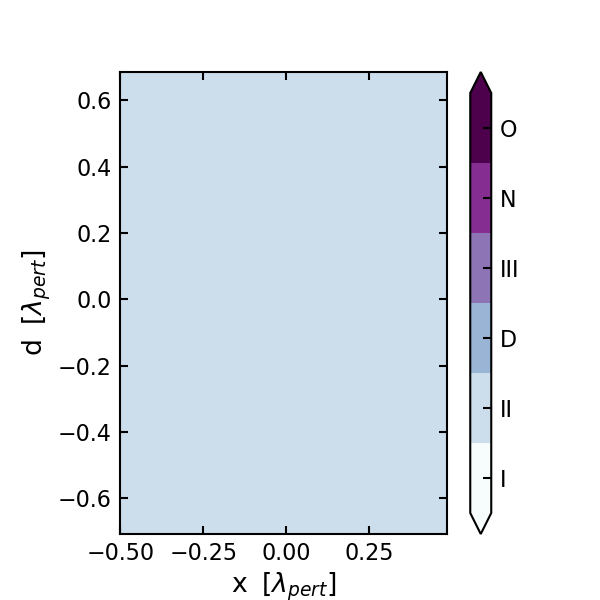

Text(0.5, 0, 'x$\\;\\;[\\lambda_{pert}]$')

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
cmap = plt.cm.get_cmap('BuPu', 6)
plt.pcolormesh(xyz/L, xyz*np.sqrt(2)/L, Petrov_class_diag, cmap=cmap, vmin=0.5, vmax=6.5, shading='gouraud')
plt.gca().set_aspect("equal")
cbar = plt.colorbar(extend='both', ticks=[1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['I', 'II', 'D', 'III', 'N', 'O'])
plt.ylabel('d'+r'$\;\;[\lambda_{pert}]$')
plt.xlabel('x'+r'$\;\;[\lambda_{pert}]$')

# Type II